Research articles for inspiration:

Akinnuwesi, B. A. (2022, October 19). Application of support vector machine algorithm for early differential diagnosis of prostate cancer. Data Science and Management. https://www.sciencedirect.com/science/article/pii/S2666764922000443

Khorshid, S. F., & Abdulazeez, A. M. (2021, February 15). Breast cancer diagnosis based on K-Nearest Neighbors: A Review. PalArch’s Journal of Archaeology of Egypt / Egyptology. https://archives.palarch.nl/index.php/jae/article/view/6601

Limitations: Models become more inefficient in handling high - dimensional and multi-classification data.

Approach: Utilise a multi-step approach in data classification by using a number of models. Utilise models that perform well with complex, multi-class data on top of models that are efficient in binary classification.


# Data Pre-processing

Loading data and performing simple exploratory analysis:

In [1]:
import numpy as np
import pandas as pd

cancer = pd.read_csv("Train_Set.csv")
# About 350 features

cancer.info()
cancer.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2193 entries, 0 to 2192
Columns: 351 entries, length_51 to class_label
dtypes: float64(350), object(1)
memory usage: 5.9+ MB


,length_51,length_52,length_53,length_54,length_55,length_56,length_57,length_58,length_59,length_60,...,length_391,length_392,length_393,length_394,length_395,length_396,length_397,length_398,length_399,length_400
count,2193.000000,2193.000000,2193.000000,2193.000000,2193.000000,2193.000000,2193.000000,2193.000000,2193.000000,2193.000000,...,2193.000000,2193.000000,2193.000000,2193.000000,2193.000000,2193.000000,2193.000000,2193.000000,2193.000000,2193.000000
mean,0.006481,0.006008,0.005988,0.006060,0.006290,0.006771,0.007466,0.008759,0.010395,0.011411,...,0.012359,0.011886,0.011411,0.010904,0.010408,0.009958,0.009503,0.009131,0.008747,0.008415
std,0.006746,0.006086,0.006054,0.005993,0.006205,0.006739,0.007542,0.009192,0.011396,0.012763,...,0.008149,0.007805,0.007517,0.007135,0.006833,0.006561,0.006235,0.006017,0.005747,0.005516
min,0.000032,0.000030,0.000022,0.000027,0.000040,0.000038,0.000040,0.000051,0.000049,0.000087,...,0.002320,0.002242,0.002067,0.002086,0.001965,0.001843,0.001731,0.001698,0.001659,0.001567
25%,0.001378,0.001273,0.001326,0.001387,0.001523,0.001646,0.001867,0.002260,0.002737,0.003024,...,0.007085,0.006759,0.006528,0.006232,0.005922,0.005651,0.005429,0.005268,0.005047,0.004868
50%,0.005429,0.005047,0.005021,0.005203,0.005286,0.005657,0.006068,0.006904,0.007943,0.008646,...,0.010115,0.009691,0.009214,0.008894,0.008412,0.008024,0.007695,0.007378,0.007011,0.006708
75%,0.009495,0.008846,0.008716,0.008813,0.009160,0.009723,0.010538,0.012197,0.013973,0.014923,...,0.015154,0.014573,0.014064,0.013267,0.012660,0.012156,0.011621,0.011155,0.010666,0.010283
max,0.079471,0.069445,0.069445,0.067825,0.071855,0.078914,0.091267,0.113398,0.140649,0.157588,...,0.062695,0.061578,0.060024,0.058549,0.056764,0.055813,0.054001,0.052768,0.051798,0.049086


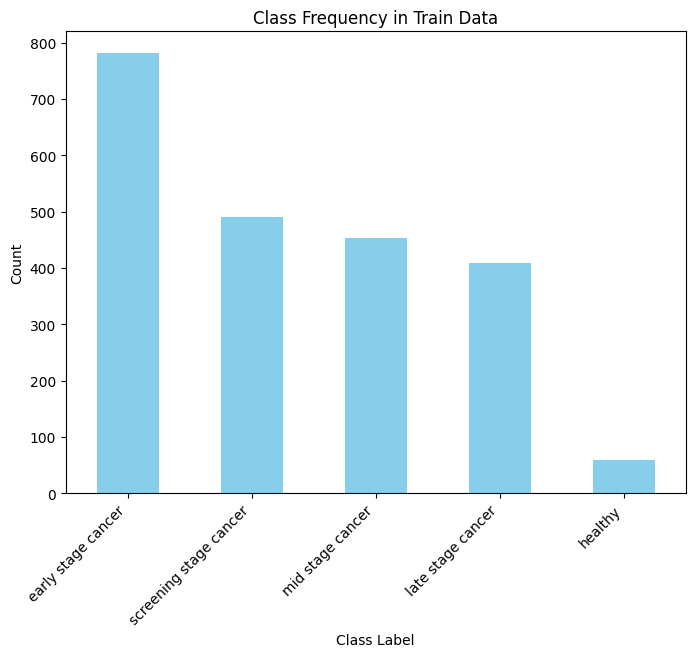

In [2]:
import matplotlib.pyplot as plt
class_counts = cancer["class_label"].value_counts()

# Plotting the counts
plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar', color='skyblue')
plt.title('Class Frequency in Train Data')
plt.xlabel('Class Label')
plt.ylabel('Count')

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')
plt.show()

# We can see that data is imbalanced with many samples being "early stage cancer" and few "healthy".

Training data

In [2]:
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from numpy import mean
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer, recall_score
from xgboost import XGBClassifier

combine_class = cancer.copy()

# Combining healthy and screening cancer into one class for the first classifier
cancer_class = {"healthy":0, "late stage cancer":1, "screening stage cancer":0, "early stage cancer":2, "mid stage cancer":3}
combine_class['class_label'] = combine_class['class_label'].map(cancer_class)
new_class = ['healthy+screening', 'late stage cancer', 'early stage cancer', 'mid stage cancer']

X = combine_class.iloc[:,:-1].values
y = combine_class.iloc[:,-1].values

# Normalizing
X = preprocessing.normalize(X, axis=1)

# Splitting the data into a train and a validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.20, random_state = 100)

cancer_2stage = cancer.copy()
# Preprocessing training data for second classifier
filtered_train = cancer_2stage[cancer_2stage['class_label'].isin(['healthy', 'screening stage cancer'])]

# Make class labels numeric according to the defined mapping
label_mapping = {"healthy": 0, "screening stage cancer": 1}
filtered_train['class_label'] = filtered_train['class_label'].map(label_mapping)

# Separate features and response variable
X_2 = filtered_train.drop(columns=['class_label']).values
y_2 = filtered_train['class_label'].values

# Normalize the features using standard scaler
scaler = StandardScaler()
X_train2 = scaler.fit_transform(X_2)

# Split data into train and validation
#X_train2, X_val2, y_train2, y_val2 = train_test_split(X_2, y_2, test_size=0.25, random_state=100)


C:\Users\Shailesh\AppData\Local\Temp\ipykernel_20812\3669732135.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_train['class_label'] = filtered_train['class_label'].map(label_mapping)


Test Data

### Retreive test set
test_data = pd.read_csv("Test_Set.csv")
combine = test_data.copy()

# Combining classes helthy and screening stage cancer for the first classifier
cancer_class_test = {"healthy":0, "late stage cancer":1, "screening stage cancer":0, "early stage cancer":2, "mid stage cancer":3}
combine['class_label'] = combine['class_label'].map(cancer_class_test)
combined_class = ['healthy+screening', 'late stage cancer', 'early stage cancer', 'mid stage cancer']

X_test = combine.iloc[:,:-1].values
y_test_combined = combine.iloc[:,-1].values

# Normalizing test data
X_test = preprocessing.normalize(X_test, axis=1)


test_2stage = test_data.copy()
#Preprocessing test data for second classifier
filtered_test = test_2stage[test_2stage['class_label'].isin(['healthy', 'screening stage cancer'])]

# Make class labels numeric according to the defined mapping
label_mapping = {"healthy": 0, "screening stage cancer": 1}
filtered_test['class_label'] = filtered_test['class_label'].map(label_mapping)

# Separate features and response variable
X_test2 = filtered_test.drop(columns=['class_label']).values
y_test2 = filtered_test['class_label'].values

# Normalize the features using standard scaler
X_test2 = scaler.transform(X_test2)


# Model Building, Training and Evaluation

## Models for classification step 1:

The first model in this two step process classifies the data into 'healthy+screening', 'late stage cancer', 'early stage cancer' or 'mid stage cancer'. Two different algorithms were tested for this: Random Forest and a Neural Network.

### Decision Trees, random forest:

Hyperparameter tuning using a validation set

In [5]:
recall = make_scorer(recall_score, average="weighted")
run_forest_run = RandomForestClassifier()
forest_params = [{"n_estimators": [10,25,50,75,100], "criterion": ["entropy", "gini"], "class_weight": ["balanced", None], "bootstrap": [True, False], "max_depth": [6,8,10]}]
forest_best_params = GridSearchCV(run_forest_run, param_grid=forest_params, cv=5, scoring=recall, refit=False)
forest_best_params.fit(X_train, y_train)
print(forest_best_params.best_params_)
print(forest_best_params.best_score_)

{'bootstrap': False, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 100}
0.8991078551078552


Results for Random Forest on validation data

In [6]:
#Training the decision tree
rf_classifier = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 42, class_weight="balanced", bootstrap=False, max_depth=10)
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_val)

print("Combining screening and healthy class")
print(classification_report(y_val, y_pred, target_names=new_class))

Combining screening and healthy class
                    precision    recall  f1-score   support

 healthy+screening       0.95      0.90      0.93       126
 late stage cancer       0.97      0.92      0.95        79
early stage cancer       0.88      0.94      0.91       152
  mid stage cancer       0.89      0.88      0.88        82

          accuracy                           0.92       439
         macro avg       0.92      0.91      0.92       439
      weighted avg       0.92      0.92      0.92       439



Results for Random Forest on Test data

In [7]:
y_actual_pred = rf_classifier.predict(X_test)
print(classification_report(y_test_combined, y_actual_pred, target_names=new_class))

                    precision    recall  f1-score   support

 healthy+screening       0.73      0.60      0.66       271
 late stage cancer       0.85      0.83      0.84       189
early stage cancer       0.65      0.71      0.68       368
  mid stage cancer       0.64      0.70      0.67       206

          accuracy                           0.70      1034
         macro avg       0.72      0.71      0.71      1034
      weighted avg       0.71      0.70      0.70      1034



### Neural Network


In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
import numpy as np
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# Assuming y_train and y_actual_test are available from previous steps

# Convert labels to one-hot encoding
num_classes = len(np.unique(y_train))
y_train_one_hot = to_categorical(y_train, num_classes)
y_val_one_hot = to_categorical(y_val, num_classes)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

# Neural network architecture
model = Sequential([
    Dense(100, activation='relu', input_shape=(X_train.shape[1],)),  # More neurons
    Dropout(0.1),  # Adjust dropout rate
    Dense(100, activation='relu'),  # Added depth
    Dropout(0.1),
    Dense(num_classes, activation='softmax')
])

# Compile the model with precision and recall as metrics
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['Precision', 'Recall'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with class weights
history = model.fit(X_train, y_train_one_hot, epochs=100, batch_size=32, validation_split=0.2,
                    class_weight=class_weights_dict, callbacks=[early_stopping])

# Evaluate the model
y_pred_one_hot = model.predict(X_val)
y_pred = np.argmax(y_pred_one_hot, axis=1)  # Convert predictions from one-hot encoding


## Repeat for test set##
# Convert labels to one-hot encoding
num_classes = len(np.unique(y_train))
y_train_one_hot2 = to_categorical(y_train, num_classes)
y_test_one_hot = to_categorical(y_test_combined, num_classes)

# Compute class weights
class_weights2 = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict2 = dict(enumerate(class_weights2))

# Neural network architecture
model2 = Sequential([
    Dense(100, activation='relu', input_shape=(X_train.shape[1],)),  # More neurons
    Dropout(0.1),  # Adjust dropout rate
    Dense(100, activation='relu'),  # Added depth
    Dropout(0.1),
    Dense(num_classes, activation='softmax')
])

# Compile the model with precision and recall as metrics
model2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['Precision', 'Recall'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with class weights
history2 = model2.fit(X_train, y_train_one_hot2, epochs=100, batch_size=32, validation_split=0.2,
                    class_weight=class_weights_dict2, callbacks=[early_stopping])

# Evaluate the model
y_pred_one_hot2 = model.predict(X_test)
y_pred2 = np.argmax(y_pred_one_hot2, axis=1)  # Convert predictions from one-hot encoding


C:\Users\Shailesh\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - Precision: 0.1111 - Recall: 2.2517e-04 - loss: 1.3476 - val_Precision: 1.0000 - val_Recall: 0.0399 - val_loss: 1.2098
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Precision: 0.9395 - Recall: 0.0895 - loss: 1.1084 - val_Precision: 0.8871 - val_Recall: 0.1567 - val_loss: 0.9675
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Precision: 0.8133 - Recall: 0.1563 - loss: 0.9209 - val_Precision: 0.6648 - val_Recall: 0.3390 - val_loss: 0.9004
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Precision: 0.6635 - Recall: 0.2532 - loss: 0.8724 - val_Precision: 0.7197 - val_Recall: 0.3219 - val_loss: 0.8546
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Precision: 0.6674 - Recall: 0.3145 - loss: 0.8498 - val_Precision: 0.7244 - val_Recall: 0.3219 - val_loss: 0.8252
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Precision: 0.6358 - Recall: 0.3233 - loss: 0.8415 - val_Precision: 0.6968 - val_Recall: 0.3732 - val_loss: 

C:\Users\Shailesh\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - Precision: 0.2000 - Recall: 0.0017 - loss: 1.3533 - val_Precision: 0.9348 - val_Recall: 0.1225 - val_loss: 1.1720
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Precision: 0.8693 - Recall: 0.1242 - loss: 1.0948 - val_Precision: 0.8219 - val_Recall: 0.1709 - val_loss: 0.9441
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Precision: 0.7917 - Recall: 0.1708 - loss: 0.9228 - val_Precision: 0.6506 - val_Recall: 0.3077 - val_loss: 0.8944
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Precision: 0.6364 - Recall: 0.3043 - loss: 0.8751 - val_Precision: 0.7006 - val_Recall: 0.3134 - val_loss: 0.8528
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Precision: 0.7002 - Recall: 0.3222 - loss: 0.8183 - val_Precision: 0.6860 - val_Recall: 0.3362 - val_loss: 0.8451
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Precision: 0.6489 - Recall: 0.3291 - loss: 0.8253 - val_Precision: 0.6705 - val_Recall: 0.3305 - val_loss: 0.8265
Epoch 7/1

Results for Neural Network


In [9]:
# Print classification report for validation set
print("Neural Network Model (Validation)")
target_names = ['healthy+screening', 'late stage cancer', 'early stage cancer', 'mid stage cancer']
print(classification_report(y_val, y_pred, target_names=target_names))

# Print classification report for Test Set
print("Neural Network Model (Test Set)")
target_names = ['healthy+screening', 'late stage cancer', 'early stage cancer', 'mid stage cancer']
print(classification_report(y_test_combined, y_pred2, target_names=target_names))

Neural Network Model (Validation)
                    precision    recall  f1-score   support

 healthy+screening       0.82      0.65      0.73       126
 late stage cancer       0.92      0.89      0.90        79
early stage cancer       0.69      0.74      0.71       152
  mid stage cancer       0.65      0.79      0.71        82

          accuracy                           0.75       439
         macro avg       0.77      0.77      0.76       439
      weighted avg       0.76      0.75      0.75       439

Neural Network Model (Test Set)
                    precision    recall  f1-score   support

 healthy+screening       0.71      0.59      0.64       271
 late stage cancer       0.91      0.87      0.89       189
early stage cancer       0.67      0.73      0.70       368
  mid stage cancer       0.74      0.81      0.77       206

          accuracy                           0.74      1034
         macro avg       0.76      0.75      0.75      1034
      weighted avg       0.74

## Models for classification step 2:

The second model in this process classifies data into "healthy" or "screening stage cancer". The two algorithms that were tested for this was XGBoost and Gaussian Naive Bayes.

### XGBoost

Initializing a XGBoost Model and using GridSearchCV to optimise the "scale_pos_weight" hyperparameter to come up with the best model.

In [6]:
# Initialize XGBoost classifier
model_xgb = XGBClassifier()

# Hyperparameter grid for GridSearchCV
param_grid_xgb = {
     'scale_pos_weight': [1000, 2000, 3000, 4000]
}

# Perform GridSearchCV for hyperparameter tuning with Stratified cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search_xgb = GridSearchCV(estimator=model_xgb, param_grid=param_grid_xgb, cv=cv, scoring="f1")
#grid_search_xgb.fit(X_train2, y_2) #X_train2 is used as it is standardised.

# Obtain best "scale_pos_weight" value
#best_scale_pos_weight = grid_search_xgb.best_params_['scale_pos_weight']
#print("Best scale_pos_weight:", best_scale_pos_weight)


# Initialize best XGBoost classifier with the best "scale_pos_weight"
model_xgb_best = XGBClassifier(scale_pos_weight=4000)


# Train the model on the train data
model_xgb_best.fit(X_train2, y_2)
model_xgb_best.objective)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Using the XGB model with best_scale_pos_weight to predict, classes based on test data.
Outputting Classification Report


In [11]:
y_pred_test = model_xgb_best.predict(X_test2)
print("Classification Report of Weighted XGBClassifier:")
print(classification_report(y_test2, y_pred_test))

Classification Report of Weighted XGBClassifier:
              precision    recall  f1-score   support

           0       0.67      0.10      0.17        41
           1       0.86      0.99      0.92       230

    accuracy                           0.86       271
   macro avg       0.76      0.54      0.55       271
weighted avg       0.83      0.86      0.81       271



### Naive Bayes (Gaussian Naive Bayes)

              precision    recall  f1-score   support

           0       0.29      0.10      0.15        41
           1       0.86      0.96      0.90       230

    accuracy                           0.83       271
   macro avg       0.57      0.53      0.52       271
weighted avg       0.77      0.83      0.79       271



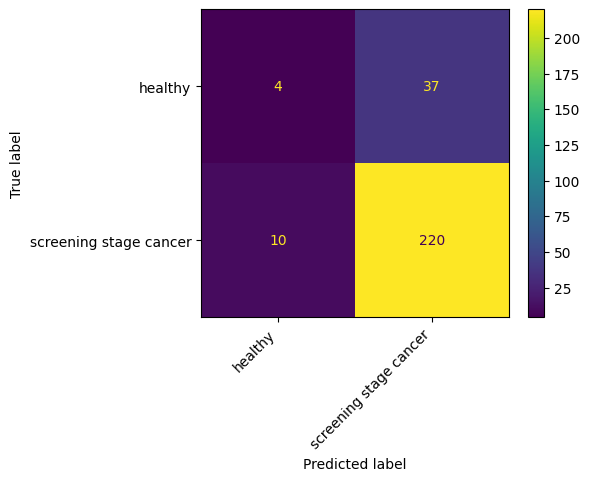

In [12]:
from sklearn.naive_bayes import GaussianNB  # Since we have continuous data, the most appropriate type of NB is the Gaussian Naive Bayes.
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)

# Define and train model
gaussian_nb = GaussianNB()
gaussian_nb.fit(X_train2, y_2)

# Test:
y_pred = gaussian_nb.predict(X_test2)

# Calculate model performance metrics
print(classification_report(y_test2, y_pred))

# Create confusion matrix
conf_matrix = confusion_matrix(y_test2, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_mapping.keys())

# Display confusion matrix
# Adjusting size of display
fig, ax = plt.subplots(figsize=(5, 4))
disp.plot(ax=ax)  # Pass the axis object to the plot method
# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')
plt.show()